In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val

from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats


<h3> funzioni

In [2]:
def gaussian(x, amp, mu, sigma, fondo):   # funzione gaussiana
    return amp * norm.pdf(x,loc = mu,scale = sigma) + fondo

def read(file, s, m, skip_header=True):    # funzione di lettura
    if skip_header:
        s += 1  # Skip the header row
    return np.loadtxt(file, unpack=True, skiprows=s, max_rows=m, delimiter=',')

def fittiamo(x_data, y_data, p0 = [1, 1, 1, 1]):    # funzione fit e ottimizzazione
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0)
    # amp_fit, mu_fit, sigma_fit, offset_fit = popt      giusto per capire cosa spara fuori popt
    return popt, pcov    

def plottiamo_plotly(data):
    
    fig = go.Figure()
    X, Y = data
    popt, pcov = fittiamo(*data)
    fwhm = FWHM(popt)
    
    fig.add_trace(go.Scatter(x = X, y = Y, mode = 'lines', line_color = 'plum', 
                             showlegend=False, hoverinfo='skip'))

    fig.add_trace(go.Scatter(x = X, y = gaussian(X, *popt), mode='lines', showlegend=False,
        marker = dict(color = 'purple')))

    fig.update_layout(
            yaxis_title = "Gray Value",
            xaxis_title = "Distance (μm)",
            plot_bgcolor = 'white',
            font = dict(
                size = 18,
                color = "Black"
            )
        )

    fig.update_xaxes(
        mirror = True,
        ticks = 'outside',
        showline = True,
        linecolor = 'black',
        gridcolor = 'lightgrey'
    )
    fig.update_yaxes(
        mirror = True,
        ticks = 'outside',
        showline = True,
        linecolor = 'black',
        gridcolor = 'lightgrey'
    )

    # Aggiungi annotazione per il valore della FWHM in alto a destra
    fig.add_annotation(
        x=max(X),  # Posizione x al massimo valore di X
        y=max(Y),  # Posizione y al massimo valore di Y
        text=f"FWHM = {fwhm:.2f}",  # Testo da mostrare
        showarrow=False,
        font=dict(
            size=14,
            color="black"
        ),
        align="right",
        xanchor="right",
        yanchor="top"
    )

    fig.show()
    return popt, pcov

def FWHM(popt):
    fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2] * 1000
    return fwhm

<h3> Risoluzione olio

In [3]:
def risoluz_olio():
    n_olio = 1.47
    NA = n_olio * np.sin(np.pi / 6)
    l_verde = 550
    return ((1.22 * l_verde) / (2 * NA)) * 0.6

risol_giusta = risoluz_olio()
print(f"risoluzione attesa = {risol_giusta:.2f}")

risoluzione attesa = 273.88


# Gaussiane filini rossi


In [4]:
skiprows = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
maxrows = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
risol_rosso, risol_verde = [], []
data_rosso, data_verde = [], []

In [5]:
def plot_and_resolution(i):
    data = np.array(read(f'data_vera/r{i}.csv', s = skiprows[i - 1], m = maxrows[i - 1]))
    popt, pcov = plottiamo_plotly(data)  # scegliere plotly o pyplot
    fwhm = FWHM(popt)
    risol_rosso.append(fwhm)
    print(f"FWHM = {fwhm:.2f}")
    data_rosso.append(data)

In [6]:
for i in range(1, 11):
    plot_and_resolution(i)
    print(i)

FWHM = 223.52
1


FWHM = 252.13
2


FWHM = 363.27
3


FWHM = 228.01
4


FWHM = 293.54
5


FWHM = 204.00
6


FWHM = 184.96
7


FWHM = 254.66
8


FWHM = 202.90
9


FWHM = 217.18
10


In [7]:
# Calcolo della media
media_risoluzione = np.mean(risol_rosso)

# Calcolo della deviazione standard con correzione di Bessel
dev_std_risoluzione = np.std(risol_rosso, ddof=1)

# Calcolo dell'errore standard della media
errore_std_media = dev_std_risoluzione / np.sqrt(len(risol_rosso))

# Stampa dei risultati
print(f"Media della risoluzione: {media_risoluzione:.2f}")
print(f"Deviazione standard (correzione di Bessel): {dev_std_risoluzione:.2f}")
print(f"Errore standard della media: {errore_std_media:.2f}")

Media della risoluzione: 242.42
Deviazione standard (correzione di Bessel): 52.71
Errore standard della media: 16.67


In [8]:
# Calcolo del valore t
t_value = (media_risoluzione - risol_giusta) / errore_std_media

# Calcolo del p-value (test a due code)
p_value = 2 * (1 - stats.t.cdf(abs(t_value), df=len(risol_rosso) - 1))

# Stampa dei risultati
print(f"Valore t: {t_value:.2f}")
print(f"P-value: {p_value:.4f}")

# Verifica se il test t è accettabile (p-value > 0.05)
if p_value > 0.05:
    print("Il test t è accettabile: non ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.")
else:
    print("Il test t non è accettabile: ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.")

Valore t: -1.89
P-value: 0.0917
Il test t è accettabile: non ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.


# Risoluzione filini verdi

In [9]:
def plot_and_resolution_v(i):
    data = np.array(read(f'data_vera/g{i}.csv', s = skiprows[i - 1], m = maxrows[i - 1]))
    popt, pcov = plottiamo_plotly(data)  # scegliere plotly o pyplot
    fwhm = FWHM(popt)
    risol_verde.append(fwhm)
    print(f"FWHM = {fwhm:.2f}")
    data_verde.append(data)

In [10]:
for i in range(1, 11):
    plot_and_resolution_v(i)
    print(i)

FWHM = 243.07
1


FWHM = 237.17
2


FWHM = 250.08
3


FWHM = 245.27
4


FWHM = 242.58
5


FWHM = 312.74
6


FWHM = 258.72
7


FWHM = 263.02
8


FWHM = 297.14
9


FWHM = 240.36
10


In [11]:
# Calcolo della media
media_risoluzione_verde = np.mean(risol_verde)

# Calcolo della deviazione standard con correzione di Bessel
dev_std_risoluzione_verde = np.std(risol_verde, ddof=1)

# Calcolo dell'errore standard della media
errore_std_media_verde = dev_std_risoluzione_verde / np.sqrt(len(risol_verde))

# Stampa dei risultati
print(f"Media della risoluzione verde: {media_risoluzione_verde:.2f}")
print(f"Deviazione standard (correzione di Bessel): {dev_std_risoluzione_verde:.2f}")
print(f"Errore standard della media: {errore_std_media_verde:.2f}")

# Calcolo del valore t
t_value_verde = (media_risoluzione_verde - risol_giusta) / errore_std_media_verde

# Calcolo del p-value (test a due code)
p_value_verde = 2 * (1 - stats.t.cdf(abs(t_value_verde), df=len(risol_verde) - 1))

# Stampa dei risultati
print(f"Valore t: {t_value_verde:.2f}")
print(f"P-value: {p_value_verde:.4f}")

# Verifica se il test t è accettabile (p-value > 0.05)
if p_value_verde > 0.05:
    print("Il test t è accettabile: non ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.")
else:
    print("Il test t non è accettabile: ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.")

Media della risoluzione verde: 259.01
Deviazione standard (correzione di Bessel): 25.76
Errore standard della media: 8.15
Valore t: -1.82
P-value: 0.1014
Il test t è accettabile: non ci sono evidenze sufficienti per rifiutare l'ipotesi nulla.


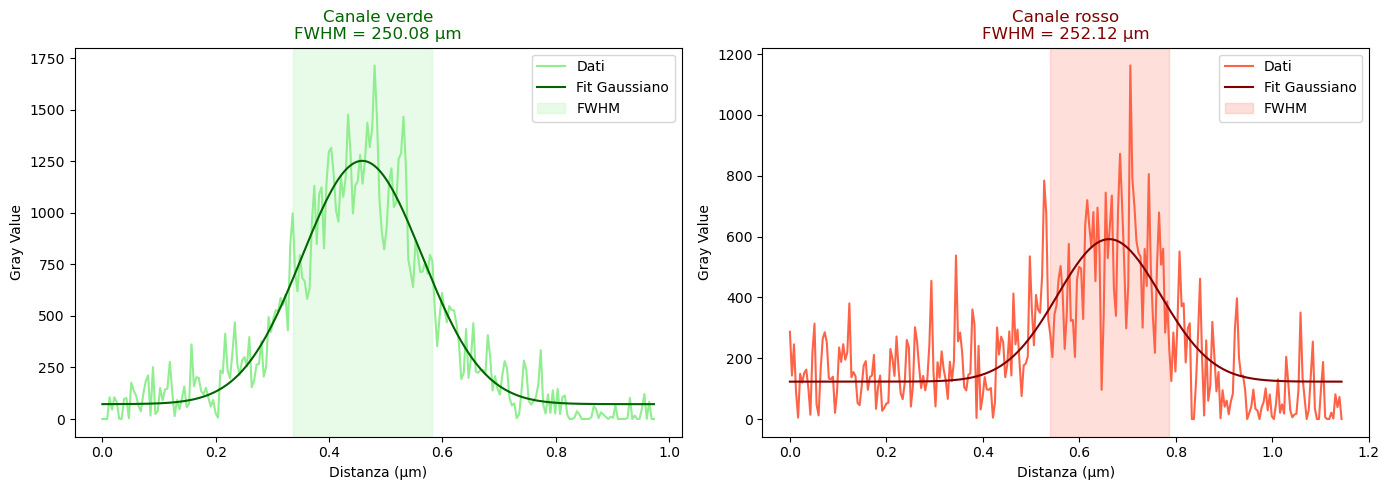

In [13]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma, fondo):
    return amp * norm.pdf(x, loc=mu, scale=sigma) + fondo

def get_fwhm_lines(X, Y):
    # Fit the gaussian
    p0 = [np.max(Y), X[np.argmax(Y)], np.std(X), np.min(Y)]
    popt, _ = curve_fit(gaussian, X, Y, p0=p0)
    # Calculate FWHM
    amp, mu, sigma, fondo = popt
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
    half_max = fondo + amp * norm.pdf(mu, loc=mu, scale=sigma) / 2
    # Find x1, x2 where gaussian crosses half max
    y_fit = gaussian(X, *popt)
    indices = np.where(y_fit >= half_max)[0]
    x1 = X[indices[0]]
    x2 = X[indices[-1]]
    return popt, x1, x2, fwhm

def plot_fwhm(ax, X, Y, color, fit_color, label):
    popt, x1, x2, fwhm = get_fwhm_lines(X, Y)
    ax.plot(X, Y, color=color, label='Dati')
    ax.plot(X, gaussian(X, *popt), color=fit_color, linestyle='-', label='Fit Gaussiano')
    ax.axvspan(x1, x2, color=color, alpha=0.2, label='FWHM')
    ax.set_title(f'{label}\nFWHM = {fwhm*1000:.2f} μm', color=fit_color)
    ax.set_xlabel('Distanza (μm)')
    ax.set_ylabel('Gray Value')
    ax.legend()
    return fwhm

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Filino verde 3
Xv, Yv = data_verde[2][0], data_verde[2][1]
fwhmv = plot_fwhm(axs[0], Xv, Yv, color='lightgreen', fit_color='darkgreen', label='Canale verde')

# Filino rosso 2
Xr, Yr = data_rosso[1][0], data_rosso[1][1]
fwhmr = plot_fwhm(axs[1], Xr, Yr, color='tomato', fit_color='maroon', label='Canale rosso')

plt.tight_layout()
plt.show()
